In [1]:
import sys
!{sys.executable} -m pip install --user -r requirements.txt

In [2]:
import inspect
import os
import sys
from operator import itemgetter
from functools import reduce
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import numpy as np
import pandas as pd
from numpy.linalg import norm
from IPython.display import display, HTML


currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir)

from pypackage.flexfringe.utils import preprocess_bidirectional_data, rolling_window, lists_identical, netflow_encoding, \
    find_percentile, date_diff, split_data, remove_background, foo, split_data2

## Helper Functions

In [3]:
def read_and_process_data(dataset):
    dataset_dir = '../data/ctu/'
    if os.path.exists(dataset_dir + 'no_background_' + dataset + '.pkl'):
        data = pd.read_pickle(
            dataset_dir + 'no_background_' + dataset + '.pkl')  # if the data without the background are there, load them

    else:
        # read the data in chunks due to their large size - uncomment the following lines if you want to read them again
        # and store them in a pickle
        preprocess_bidirectional_data(dataset_dir + dataset)
        dateparse = lambda x: pd.datetime.strptime(x, '%Y/%m/%d %H:%M:%S.%f')
        data = pd.concat(
            remove_background(chunk) for chunk in pd.read_csv(dataset_dir + dataset + '_v2',
                                                              chunksize=100000, delimiter=',',
                                                              parse_dates=['date'], date_parser=dateparse))
        data.to_pickle(dataset_dir + 'no_background_' + dataset + '.pkl')

        # ## Initial preprocessing of the data
        # resetting indices for data
    data = data.reset_index(drop=True)
    dates = data['date'].tolist()
    time_diff = [int(abs(date_diff(s, t))) for s, t in zip(dates[1:], dates)]
    time_diff = [np.mean(time_diff)] + time_diff
    # parse packets and bytes as integers instead of strings
    data['time_diff'] = time_diff
    # parse packets and bytes as integers instead of strings
    data['packets'] = data['packets'].astype(int)
    data['duration'] = data['duration'].astype(float)
    data['src_bytes'] = data['src_bytes'].astype(int)
    data['dst_bytes'] = data['dst_bytes'].astype(int)
    data['total_bytes'] = data['total_bytes'].astype(int)
    data['time_diff'] =  data['time_diff'].astype(int)

    # add the numerical representation of the categorical data
    data['protocol_num'] = pd.Categorical(data['protocol'], categories=data['protocol'].unique()).codes
    # data['state_num'] = pd.Categorical(data['state'], categories=data['state'].unique()).codes
    data['direction_num'] = pd.Categorical(data['direction'], categories=data['direction'].unique()).codes

    return data

In [4]:
def make_bar_graphs(x, y, feature):
    """
    Function for visualising the difference between numerical features (mainly packtes and bytes) for infected and
    normal hosts
    :param x: the type of the hosts
    :param y: the numerical values
    :param feature: the type of the feature
    :return: creates the wanted plot
    """
    plt.figure()
    y_pos = np.arange(len(x))
    plt.bar(y_pos, y, align='center', alpha=0.5, color=[mcolors.TABLEAU_COLORS['tab:blue'],
                                                        mcolors.TABLEAU_COLORS['tab:red']])
    plt.xticks(y_pos, x)
    plt.xlabel('Type of host')
    plt.ylabel(feature)
    plt.title('Average number of %s sent' % feature)
#     plt.show()
    plt.savefig('plots/barplot_%s.png' % feature)

In [5]:
def make_barplot(data, feature):
    """
    Function for visualising the difference between categorical features for infected and normal hosts
    :param data: the dataframe containing the data
    :return:creates the wanted plot creates the wanted plot
    """
    plt.figure()
    feature_counts = (data.groupby(['is_infected'])[feature].value_counts(normalize=True).rename('percentage').mul(100)
                         .reset_index().sort_values(feature))
    ax = sns.barplot(x=feature, y='percentage', data=feature_counts, hue='is_infected',
                     palette={0: mcolors.TABLEAU_COLORS['tab:blue'], 1: mcolors.TABLEAU_COLORS['tab:red']})
    handles, _ = ax.get_legend_handles_labels()
    ax.legend(handles, ['Normal Hosts', 'Infected host'], loc=0)
    plt.xlabel("%s type" % feature)
    plt.ylabel("Percentage of occurrences")
    plt.grid()
#     plt.show()
    plt.savefig('plots/barplot_%s.png' % feature)

## 

In [12]:
# infected and malicous IPs for scenario 1 (42)
infected_ip = '147.32.84.165'
# normal_ips = ['147.32.84.170', '147.32.84.134', '147.32.84.164', '147.32.87.36', '147.32.80.9', '147.32.87.11']
normal_ips = ['147.32.84.170', '147.32.84.164', '147.32.87.36', '147.32.80.9', '147.32.87.11']

s = 43
dataset_name = dataset = 'CTU-Malware-Capture-Botnet-{}'.format(s)
data = read_and_process_data(dataset)

infected = data[(data['src_ip'] == infected_ip)] 
infected = infected.reset_index()

normal= data[data['src_ip'].isin(normal_ips)]
normal = normal.reset_index()

## Check statistics of the data for the infected and the normal hosts to decide on the features for discretization

---------------- Stats for infected host ----------------


,direction_num,protocol_num,duration,packets,src_bytes,dst_bytes,total_bytes,time_diff,stos,dtos
count,20941.000000,20941.000000,20941.000000,20941.000000,20941.000000,20941.000000,20941.000000,20941.000000,20941.0,7695.0
mean,0.962132,0.962132,56.616504,8.487083,624.942314,972.896185,1597.838499,374.469319,0.0,0.0
std,0.190882,0.190882,308.986813,141.883639,6395.665603,9441.856304,13269.936028,961.490990,0.0,0.0
min,0.000000,0.000000,0.000000,1.000000,60.000000,0.000000,62.000000,0.000000,0.0,0.0
25%,1.000000,1.000000,1.031397,3.000000,186.000000,0.000000,186.000000,1.000000,0.0,0.0
50%,1.000000,1.000000,8.929712,3.000000,186.000000,0.000000,186.000000,45.000000,0.0,0.0
75%,1.000000,1.000000,9.028011,6.000000,372.000000,182.000000,433.000000,228.000000,0.0,0.0
max,1.000000,1.000000,3599.715820,9017.000000,270060.000000,407630.000000,560632.000000,9912.000000,0.0,0.0


---------------- Stats for normal hosts ----------------


,direction_num,protocol_num,duration,packets,src_bytes,dst_bytes,total_bytes,time_diff,stos,dtos
count,9082.000000,9082.000000,9082.000000,9082.000000,9082.000000,9.082000e+03,9.082000e+03,9082.000000,9073.0,9022.0
mean,0.353997,0.354107,14.452485,7.140057,481.360273,2.152890e+03,2.634251e+03,787.987338,0.0,0.0
std,0.488487,0.495902,112.853303,47.362268,3063.252545,4.962659e+04,5.098070e+04,2032.756809,0.0,0.0
min,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000e+00,6.000000e+01,0.000000,0.0,0.0
25%,0.000000,0.000000,0.000330,2.000000,74.000000,1.630000e+02,2.800000e+02,0.000000,0.0,0.0
50%,0.000000,0.000000,0.000443,2.000000,81.000000,3.260000e+02,4.000000e+02,1.000000,0.0,0.0
75%,1.000000,1.000000,0.019243,6.000000,272.000000,3.260000e+02,4.120000e+02,239.000000,0.0,0.0
max,4.000000,3.000000,3571.535400,3692.000000,196338.000000,4.137824e+06,4.207404e+06,10001.000000,0.0,0.0


plots created


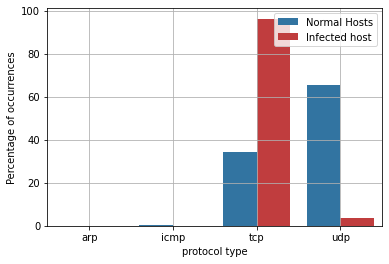

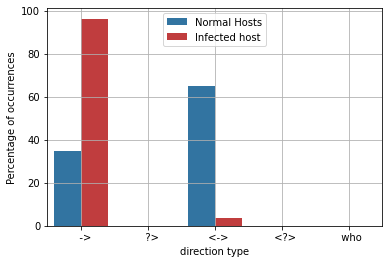

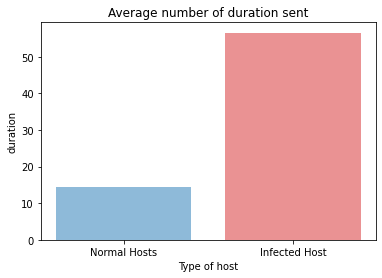

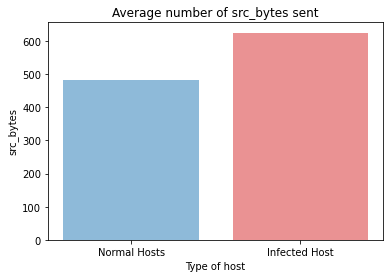

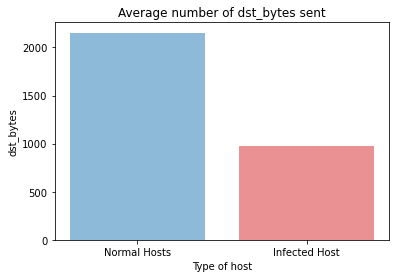

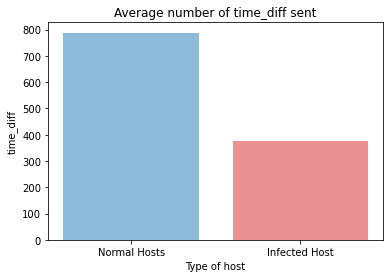

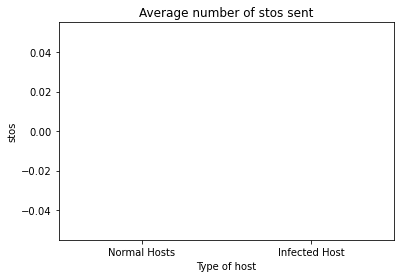

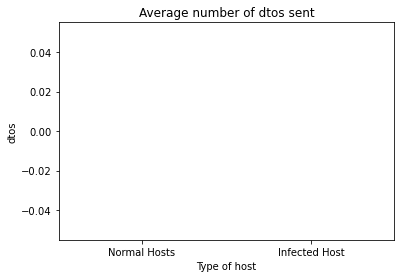

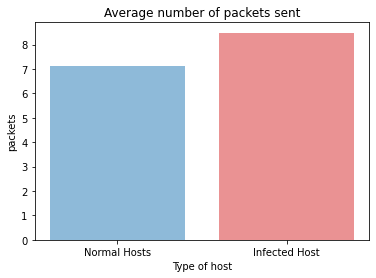

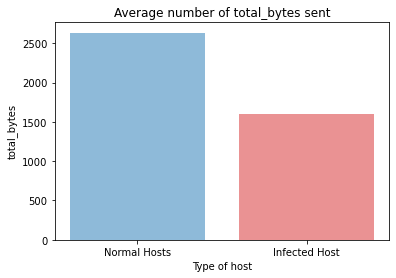

In [13]:
# separate the types of features in the dataset
continuous_features = ['direction_num', 'protocol_num', 'duration', 'packets', 
                       'src_bytes', 'dst_bytes', 'total_bytes', 'time_diff', 'stos', 'dtos']

# continuous_features = ['duration', 'protocol_num', 'flags_num', 'tos', 'packets', 'bytes', 'flows']
# categorical_features = ['protocol', 'flags']

# check statistics for the most discriminative features in the dataset
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print('---------------- Stats for infected host ----------------')
    display(HTML(infected[continuous_features].describe().to_html()))
    print('---------------- Stats for normal hosts ----------------')
    display(HTML(normal[continuous_features].describe().to_html()))

# preprocess the infected and normal data and plot possible feature candidates
plot_data = pd.concat([infected, normal], ignore_index=True)
for index, ip in enumerate(plot_data['src_ip']):
    val = 1 if ip == infected_ip else 0
    plot_data.at[index, 'is_infected'] = val

make_barplot(plot_data, 'protocol')
make_barplot(plot_data, 'direction')

make_bar_graphs(['Normal Hosts', 'Infected Host'], [normal["duration"].mean(), infected["duration"].mean()], 'duration')
make_bar_graphs(['Normal Hosts', 'Infected Host'], [normal["src_bytes"].mean(), infected["src_bytes"].mean()], 'src_bytes')
make_bar_graphs(['Normal Hosts', 'Infected Host'], [normal["dst_bytes"].mean(), infected["dst_bytes"].mean()], 'dst_bytes')
make_bar_graphs(['Normal Hosts', 'Infected Host'], [normal["time_diff"].mean(), infected["time_diff"].mean()], 'time_diff')
make_bar_graphs(['Normal Hosts', 'Infected Host'], [normal["stos"].mean(), infected["stos"].mean()], 'stos')
make_bar_graphs(['Normal Hosts', 'Infected Host'], [normal["dtos"].mean(), infected["dtos"].mean()], 'dtos')



make_bar_graphs(['Normal Hosts', 'Infected Host'], [normal["packets"].mean(), infected["packets"].mean()], 'packets')
make_bar_graphs(['Normal Hosts', 'Infected Host'], [normal["total_bytes"].mean(), infected["total_bytes"].mean()], 'total_bytes')
print('plots created')

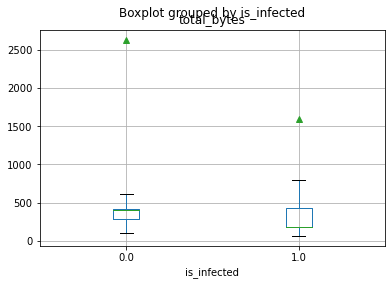

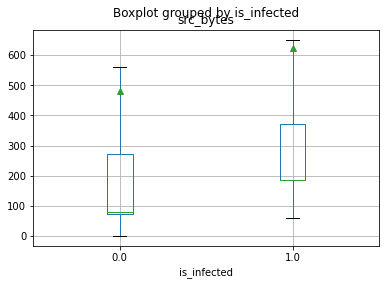

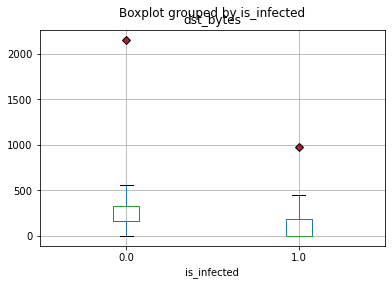

In [14]:
# separate the types of features in the dataset
continuous_features = ['direction_num', 'protocol_num', 'duration', 'packets', 
                       'src_bytes', 'dst_bytes', 'total_bytes', 'time_diff', 'stos', 'dtos']

# continuous_features = ['duration', 'protocol_num', 'flags_num', 'tos', 'packets', 'bytes', 'flows']
# categorical_features = ['protocol', 'flags']

# check statistics for the most discriminative features in the dataset
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     print('---------------- Stats for infected host ----------------')
#     display(HTML(infected[continuous_features].describe().to_html()))
#     print('---------------- Stats for normal hosts ----------------')
#     display(HTML(normal[continuous_features].describe().to_html()))

# pd.options.plotting.backend = 'matplotlib'


# preprocess the infected and normal data and plot possible feature candidates
plot_data = pd.concat([infected, normal], ignore_index=True)
for index, ip in enumerate(plot_data['src_ip']):
    val = 1 if ip == infected_ip else 0
    plot_data.at[index, 'is_infected'] = val

    
    
meanpointprops = dict(marker='D', markeredgecolor='black',
                      markerfacecolor='firebrick')

# plot_data.boxplot(by="is_infected", column="duration", showfliers=False)
# plot_data.boxplot(by="is_infected", column="src_bytes", showfliers=False)
# plot_data.boxplot(by="is_infected", column="dst_bytes", showfliers=False)
# plot_data.boxplot(by="is_infected", column="time_diff", showfliers=False)
# plot_data.boxplot(by="is_infected", column="stos", showfliers=False)
# plot_data.boxplot(by="is_infected", column="dtos", showfliers=False)
# plot_data.boxplot(by="is_infected", column="packets", showfliers=False)
plot_data.boxplot(by="is_infected", column="total_bytes", showfliers=False, showmeans=True)
plot_data.boxplot(by="is_infected", column="src_bytes", showfliers=False, showmeans=True)
plot_data.boxplot(by="is_infected", column="dst_bytes", showfliers=False, showmeans=True, meanprops = meanpointprops)

